# File Description

This notebook contains the most up-to-date version of the pilot model for total water level on Tarawa, currently for only two locations (one lagoon side and one ocean side).

Currently needs work:
- Incorporating MEI into network
- Adjusting the binning of the MSL distributions to account for future SLR
- Adding SLR projections as evidence option

# File Setup

##
How does the order of magnitude vary betwene the lagoon and the ocean?
which is most sensitive to waves? How would that interact with topography?

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython

from BNModel import BNModel

from preprocessing_all_points import *
from preprocessing_points_spatially import *

In [3]:
# ### set location of file storage
# folder = 'BN_antonio_data'
# try:
#     os.makedirs(folder)
# except FileExistsError:
#     pass

# Data Prep

## Preprocessing

In [45]:
# Import and preprocess data
df_ocean,df_lagoon = preprocessing_points_spatially()
df_lagoon,lagoon_data_dict = BN_Antonio_preprocessing_lagoon(df_lagoon)
df_ocean,ocean_data_dict = BN_Antonio_preprocessing_ocean(df_ocean)

## Create Variable Dictionary

In [5]:
#### Don't include spaces in bin names. if no discretisation, just leave out that key
lagoon_model_dict = {
    'variables':{
        'Wind_u':{
            'label':'Wind u vector (m/s)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Wind_v':{
            'label':r'Wind v vector (m/s)',
            'discretisation':{
                'n_bins':5,
                'strategy':'uniform',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Hs_offshore':{
            'label':'Offshore wave height (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','HighMid','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Tm_offshore':{
            'label':'Offshore wave period (s)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Dir_offshore':{
            'label':r'Offshore wave direction (degrees)',
            'discretisation':{
                'n_bins':8,
                'strategy':'kmeans',
                'bin_names':['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'TWL':{
            'label':'Total water level (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':[]
        },
        'TWL_less_Tide':{
            'label':'Total water level less tide (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        },
        'MSL':{
            'label':'Mean sea level (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Tide':{
            'label':'Tide (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}

In [6]:
ocean_model_dict = {
   'variables':{
       'Tm_offshore':{
            'label':'Wave period offshore (?)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Hs_offshore':{
            'label':'Wave height offshore (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Dir_offshore':{
            'label':'Wave direction offshore (degrees)',
            'discretisation':{
                'n_bins':8,
                'strategy':'kmeans',
                'bin_names':['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'MSL':{
            'label':'Mean sea level (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Tide':{
            'label':'Tide (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        },
        'TWL':{
            'label':'Total water level (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':[]
        },
        'TWL_less_Tide':{
            'label':'Total water level less tide (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        },
        'reef_width':{
            'label':'Reef width (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'reef_depth':{
            'label':'Reef depth (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'forereef_slope':{
            'label':'Fore reef slope (degrees)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        } 
   },
    'training_frac':0.8,
    'bootstrap_reps':1
}

## Bootstrapping the data

In [7]:
# Bootstrap the data, and add it to the model_dict
lagoon_model_dict = BNModel().bootstrap_data(lagoon_model_dict,lagoon_data_dict,df_lagoon)

ocean_model_dict = BNModel().bootstrap_data(ocean_model_dict,ocean_data_dict,df_ocean)

## Discretise the data

In [8]:
# Discretise the data
lagoon_file_label = "lagoon"
ocean_file_label = "ocean"

lagoon_model_dict = BNModel().discretiser(lagoon_model_dict)
ocean_model_dict = BNModel().discretiser(ocean_model_dict)

In [9]:
# lagoon_model_dict['variables']['MEI']

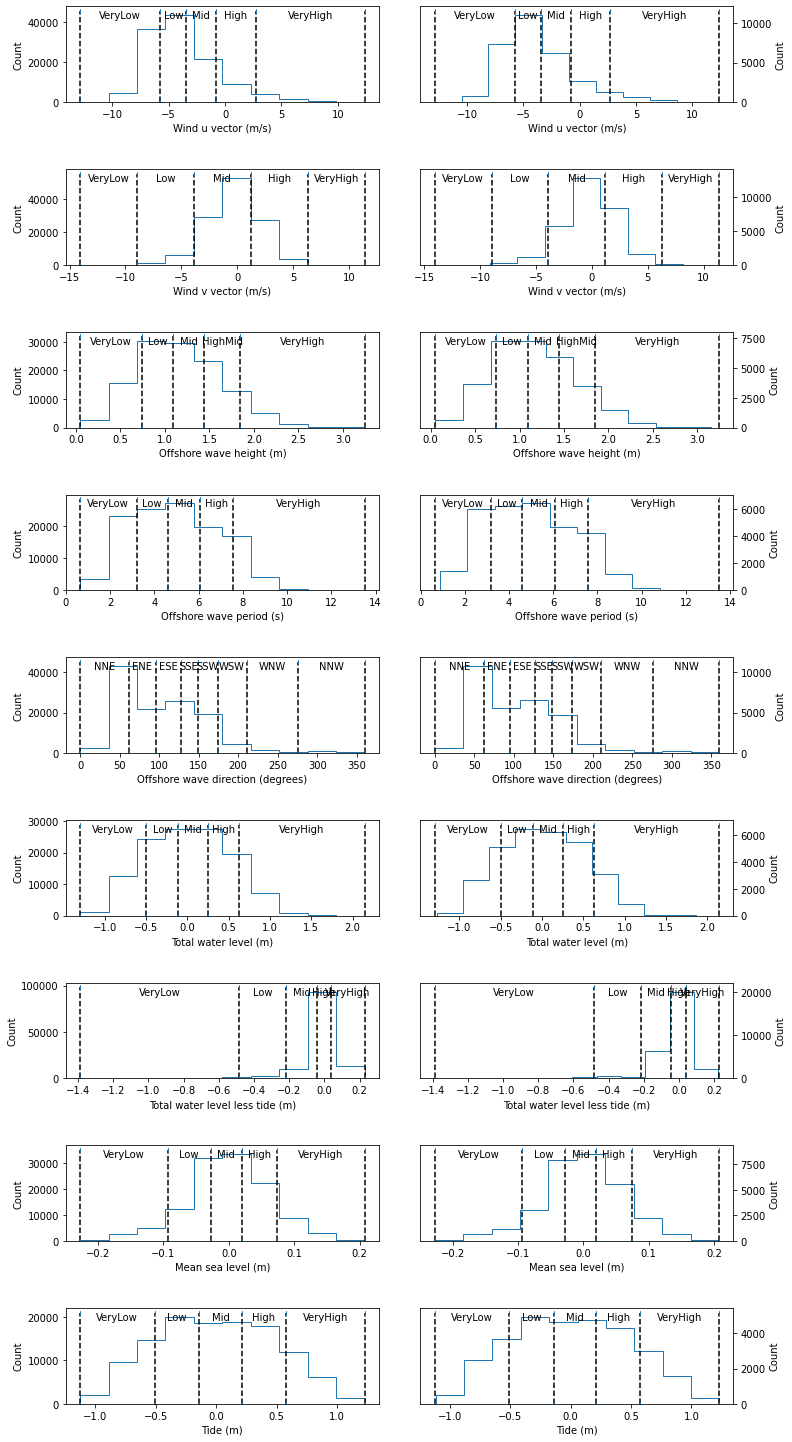

In [10]:
lagoon_disc_fig = BNModel().plot_discretiser(lagoon_model_dict)

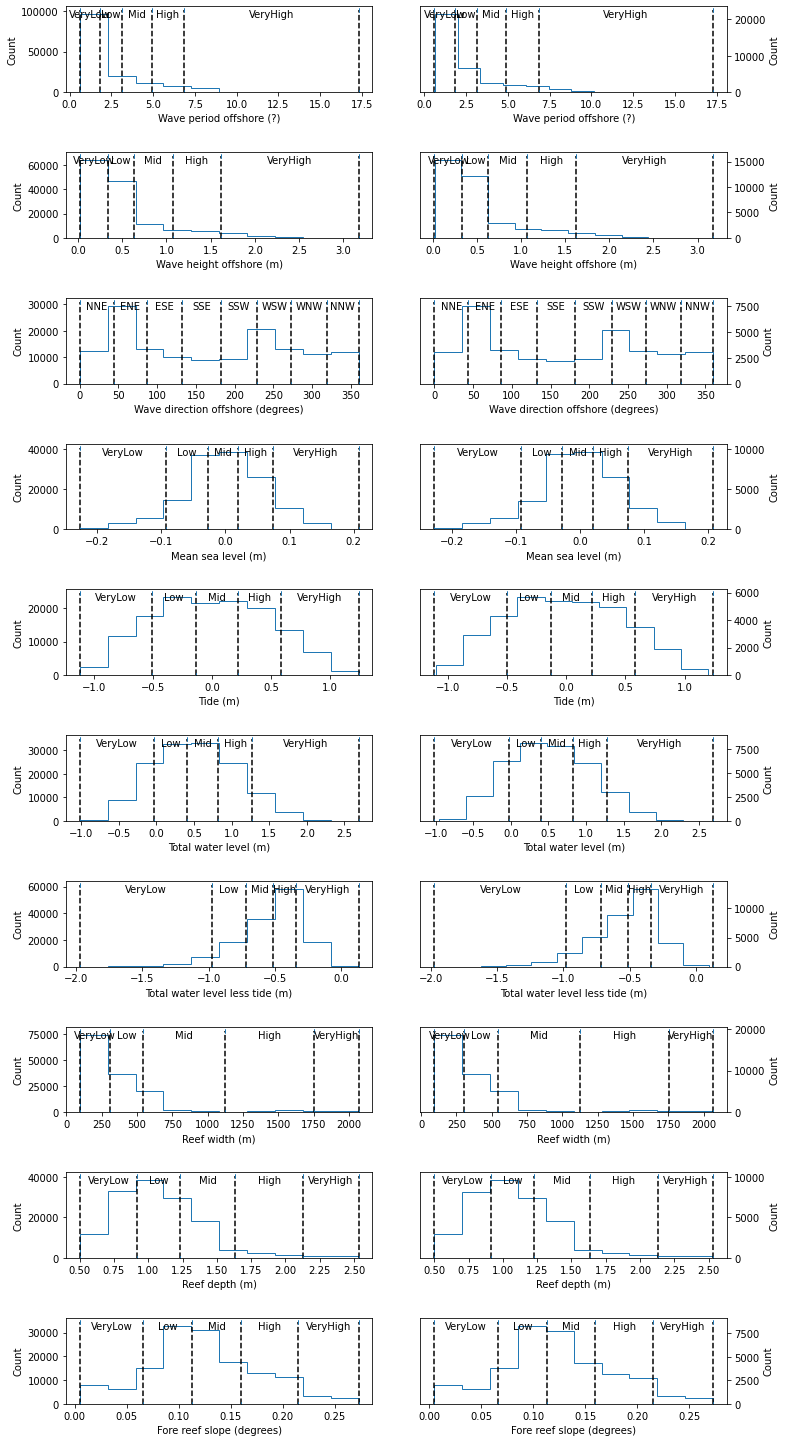

In [11]:
ocean_disc_fig = BNModel().plot_discretiser(ocean_model_dict)

## Save the data

In [12]:
BNModel().save_dataset(lagoon_model_dict,lagoon_file_label)
BNModel().save_dataset(ocean_model_dict,ocean_file_label)

# Create BN Model

In [13]:
# Create the BN
lagoon_model_dict = BNModel().create_SM(lagoon_model_dict,lagoon_file_label)

In [14]:
ocean_model_dict = BNModel().create_SM(ocean_model_dict,ocean_file_label)

## View Conditional Probability tables

In [15]:
# Get conditional probs tables
BNModel().get_conditional_prob_table(lagoon_model_dict,'TWL')

TWL_less_Tide   VeryLow                                         Low            \
Tide            VeryLow       Low       Mid High VeryHigh   VeryLow       Low   
TWL                                                                             
High           0.041284  0.578125  0.516129  0.0      0.0  0.000000  0.042118   
Low            0.495413  0.000000  0.000000  0.0      0.0  0.758416  0.154031   
Mid            0.449541  0.378906  0.000000  0.0      0.0  0.035644  0.803851   
VeryHigh       0.000000  0.042969  0.483871  1.0      1.0  0.000000  0.000000   
VeryLow        0.013761  0.000000  0.000000  0.0      0.0  0.205941  0.000000   

TWL_less_Tide                               ...      High                      \
Tide                Mid      High VeryHigh  ...   VeryLow       Low       Mid   
TWL                                         ...                                 
High           0.814536  0.213178      0.0  ...  0.000000  0.000000  0.000075   
Low            0.000000  0.000000      0.0  ...  0.012543  0.957419  0.084145   
Mid            0.159148  0.000000      0.0  ...  0.000000  0.002339  0.915780   
VeryHigh       0.026316  0.786822      1.0  ...  0.000000  0.000000  0.000000   
VeryLow        0.000000  0.000000      0.0  ...  0.987457  0.040242  0.000000   

TWL_less_Tide                     VeryHigh                                \
Tide               High  VeryHigh  VeryLow       Low       Mid      High   
TWL                                                                        
High           0.866636  0.181576      0.0  0.000000  0.000000  0.630646   
Low            0.000000  0.000000      0.0  0.778476  0.312629  0.000000   
Mid            0.133364  0.000000      0.0  0.000000  0.687371  0.369354   
VeryHigh       0.000000  0.818424      0.0  0.000000  0.000000  0.000000   
VeryLow        0.000000  0.000000      1.0  0.221524  0.000000  0.000000   

TWL_less_Tide            
Tide           VeryHigh  
TWL                      
High           0.411466  
Low            0.000000  
Mid            0.000000  
VeryHigh       0.588534  
VeryLow        0.000000  

[5 rows x 25 columns]

In [16]:
# Get conditional probs tables
df_CPT_MSL = BNModel().get_conditional_prob_table(ocean_model_dict,'TWL')

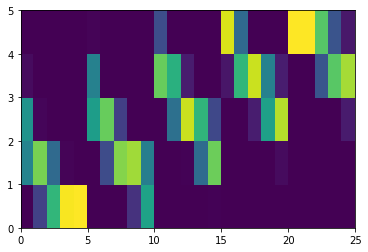

In [17]:
df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','Mid','High','VeryHigh']]

plt.pcolor(df_CPT_MSL)

In [18]:
df_CPT_MSL

Tide            VeryLow                                              Low  \
TWL_less_Tide   VeryLow       Low       Mid      High VeryHigh   VeryLow   
TWL                                                                        
VeryLow        0.000856  0.191734  0.658031  0.991998      1.0  0.000000   
Low            0.452911  0.794202  0.341969  0.008002      0.0  0.000000   
Mid            0.515411  0.014064  0.000000  0.000000      0.0  0.554633   
High           0.030822  0.000000  0.000000  0.000000      0.0  0.435144   
VeryHigh       0.000000  0.000000  0.000000  0.000000      0.0  0.010224   

Tide                                                 ...      High            \
TWL_less_Tide       Low       Mid    High  VeryHigh  ...   VeryLow       Low   
TWL                                                  ...                       
VeryLow        0.000000  0.000000  0.1431  0.574225  ...  0.000000  0.000000   
Low            0.230464  0.815276  0.8569  0.425775  ...  0.000000  0.000000   
Mid            0.767775  0.184724  0.0000  0.000000  ...  0.000000  0.000000   
High           0.001761  0.000000  0.0000  0.000000  ...  0.055699  0.657229   
VeryHigh       0.000000  0.000000  0.0000  0.000000  ...  0.944301  0.342771   

Tide                                       VeryHigh                           \
TWL_less_Tide       Mid     High  VeryHigh  VeryLow  Low       Mid      High   
TWL                                                                            
VeryLow        0.000000  0.00000  0.000000      0.0  0.0  0.000000  0.000000   
Low            0.000000  0.00000  0.027964      0.0  0.0  0.000000  0.000000   
Mid            0.078846  0.56428  0.890329      0.0  0.0  0.000000  0.000000   
High           0.917979  0.43572  0.081707      0.0  0.0  0.262932  0.741168   
VeryHigh       0.003175  0.00000  0.000000      1.0  1.0  0.737068  0.258832   

Tide                     
TWL_less_Tide  VeryHigh  
TWL                      
VeryLow        0.000000  
Low            0.000000  
Mid            0.072722  
High           0.864586  
VeryHigh       0.062692  

[5 rows x 25 columns]

# Set Evidence

In [16]:
lagoon_evidence_dict = {
    'Wind_u':[0.05,0.1,0.01,0.01,0.01],
    'Wind_v':[0.05,0.1,0.01,0.01,0.01,0.01]
}

ocean_evidence_dict = {
    'MSL':[0.05,0.1,0.01,0.01,0.01],
    'Tide':[0.05,0.1,0.01,0.01,0.01,0.01]
}

In [17]:
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,lagoon_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,ocean_evidence_dict)

# Update beliefs based on evidence

In [18]:
# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)
ocean_model_dict = BNModel().update_evidence(ocean_model_dict)

# BN Visualisation

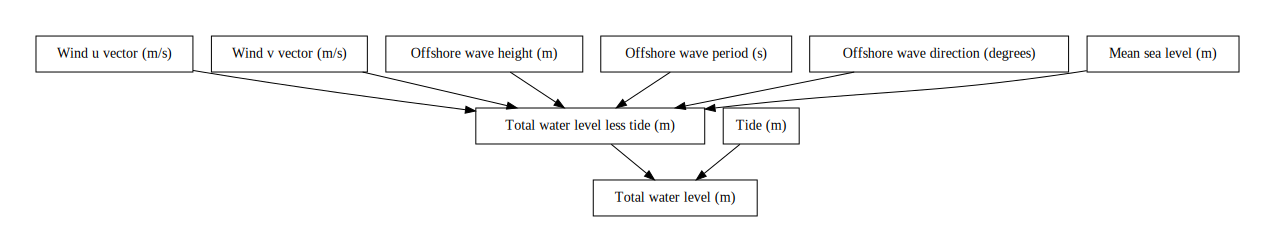

In [19]:

# Set up graph
graph_lagoon = BNModel().create_BN_graph()

# Create nodes of the graph
graph_lagoon,lagoon_model_dict = BNModel().create_nodes(graph_lagoon,lagoon_model_dict,0)

# Create arcs between nodesb
graph_lagoon = BNModel().create_arcs(graph_lagoon,lagoon_model_dict)

# Save as dot file
graph_lagoon.render(filename='graph_lagoon',format='png')

# Plot the graph
graph_lagoon


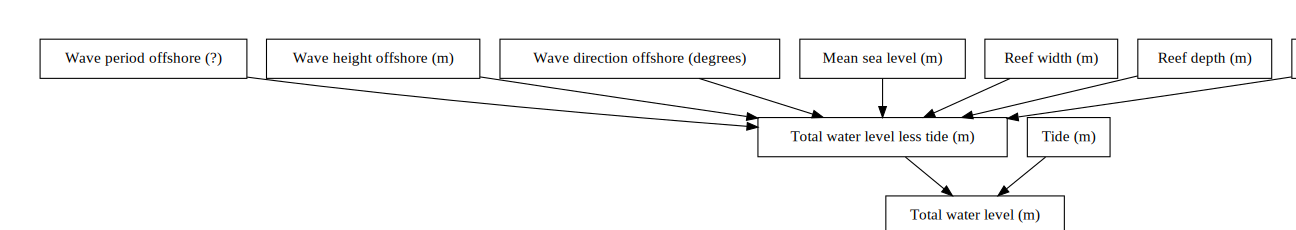

In [20]:

# Set up graph
graph_ocean = BNModel().create_BN_graph()

# Create nodes of the graph
graph_ocean,ocean_model_dict = BNModel().create_nodes(graph_ocean,ocean_model_dict,0)

# Create arcs between nodesb
graph_ocean = BNModel().create_arcs(graph_ocean,ocean_model_dict)

# Save as dot file
graph_ocean.render(filename='graph_ocean',format='png')

# Plot the graph
graph_ocean

# Model Validation

{(0, 'VeryLow'): 0.8931344503473642, (0, 'Low'): 0.8479642905451102, (0, 'Mid'): 0.8191077320327069, (0, 'High'): 0.8484753713838936, (0, 'VeryHigh'): 0.9577850877192983}


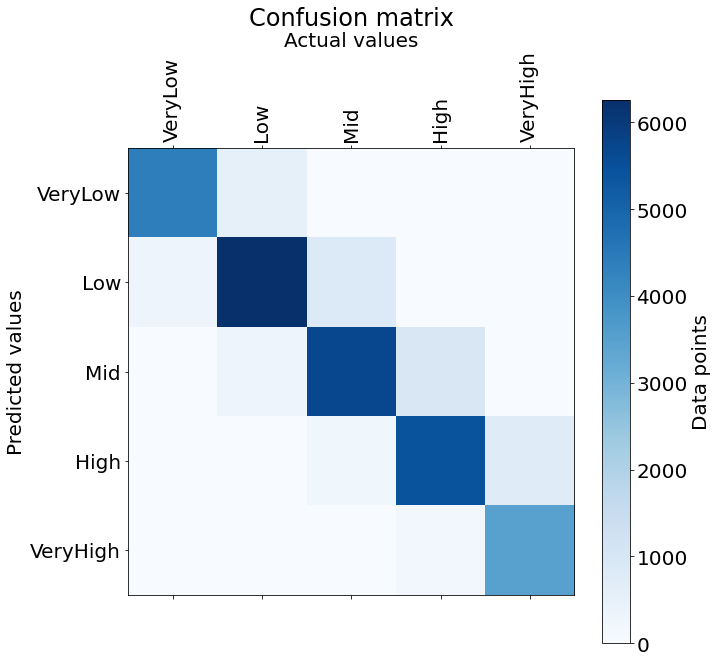

In [21]:
### Research picking number of kfolds 

lagoon_acc_dict = BNModel().get_accuracies(lagoon_model_dict,"TWL")

print(lagoon_acc_dict)

fig, ax = BNModel().confusion_matrix(lagoon_model_dict,"TWL",0)

In [25]:
np.unique(lagoon_model_dict['variables']['Wind_u']['testing_data'][0])

array(['High', 'Low', 'Mid', 'VeryHigh', 'VeryLow'], dtype='<U32')

In [51]:
np.unique(ocean_model_dict['variables']['Tide']['testing_data'][0])

array(['High', 'Low', 'Mid', 'VeryHigh', 'VeryLow'], dtype='<U32')

In [27]:
print(np.min(lagoon_model_dict['variables']['Wind_v']['testing_data_preprocessed'][0]))
print(np.max(lagoon_model_dict['variables']['Wind_v']['testing_data_preprocessed'][0]))
print(np.mean(lagoon_model_dict['variables']['Wind_v']['testing_data_preprocessed'][0]))
print(np.median(lagoon_model_dict['variables']['Wind_v']['testing_data_preprocessed'][0]))

-13.955062866210938
11.38702392578125
-0.2527384196053528
-0.200164794921875


In [28]:
lagoon_model_dict['variables']['Wind_v']

{'label': 'Wind v vector (m/s)',
 'discretisation': {'n_bins': 5,
  'strategy': 'uniform',
  'bin_names': ['VeryLow', 'Low', 'Mid', 'High', 'VeryHigh']},
 'child_nodes': ['TWL_less_Tide'],
 'training_data_preprocessed': {0: array([-1.18292236, -0.33476257,  0.5897522 , ...,  1.3394165 ,
         -2.57757568, -4.48239136])},
 'testing_data_preprocessed': {0: array([-3.05592346, -0.8621521 ,  1.46348572, ...,  4.49684143,
         -1.3145752 ,  1.79043579])},
 'training_data': {0: array(['Mid', 'Mid', 'Mid', ..., 'High', 'Mid', 'Low'], dtype='<U21')},
 'testing_data': {0: array(['Mid', 'Mid', 'High', ..., 'High', 'Mid', 'High'], dtype='<U32')},
 'bin_edges': {0: array([-14.06361389,  -8.97348633,  -3.88335876,   1.2067688 ,
           6.29689636,  11.38702393])},
 'id': 1,
 'evidence': [0.05, 0.1, 0.01, 0.01, 0.01, 0.01],
 'resulting_probs': {0: {'VeryLow': 0.000997611125790674,
   'Low': 0.3868574171039078,
   'Mid': 0.44481053477348836,
   'High': 0.16654174058875232,
   'VeryHigh': 0.

{(0, 'VeryLow'): 0.893251742308346, (0, 'Low'): 0.7026996498362137, (0, 'Mid'): 0.8420252572497662, (0, 'High'): 0.7267433396418692, (0, 'VeryHigh'): 0.7175521183591123}


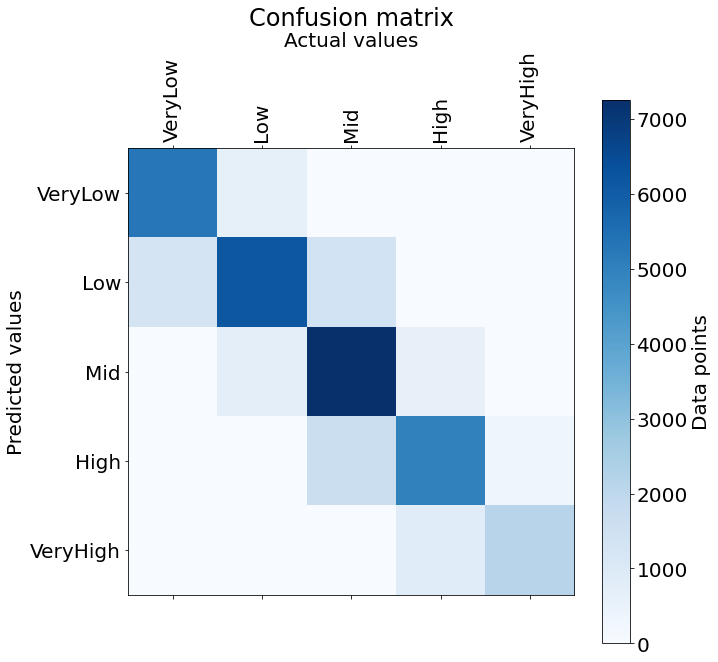

In [22]:

ocean_acc_dict = BNModel().get_accuracies(ocean_model_dict,"TWL")

print(ocean_acc_dict)

fig, ax = BNModel().confusion_matrix(ocean_model_dict,"TWL",0)

In [30]:
np.unique(ocean_model_dict['variables']['reef_width']['testing_data'])


array([{0: array(['VeryHigh', 'VeryHigh', 'VeryHigh', ..., 'Low', 'Low', 'Low'],
             dtype='<U32')}                                                     ],
      dtype=object)

In [31]:
pysmile_dict = ocean_model_dict['model'][0]
net = pysmile_dict['net']
ds_testing = pysmile_dict['ds_testing']

ds_testing

In [32]:
ds_testing.match_network(net)

In [33]:
ocean_model_dict['variables']['reef_width']['testing_data_preprocessed'][0]

array([1815.7035 , 1815.7035 , 1815.7035 , ...,  495.52852,  495.52852,
        495.52852])

# Sensitivity Analysis

## Lagoon

### Tide on TWL

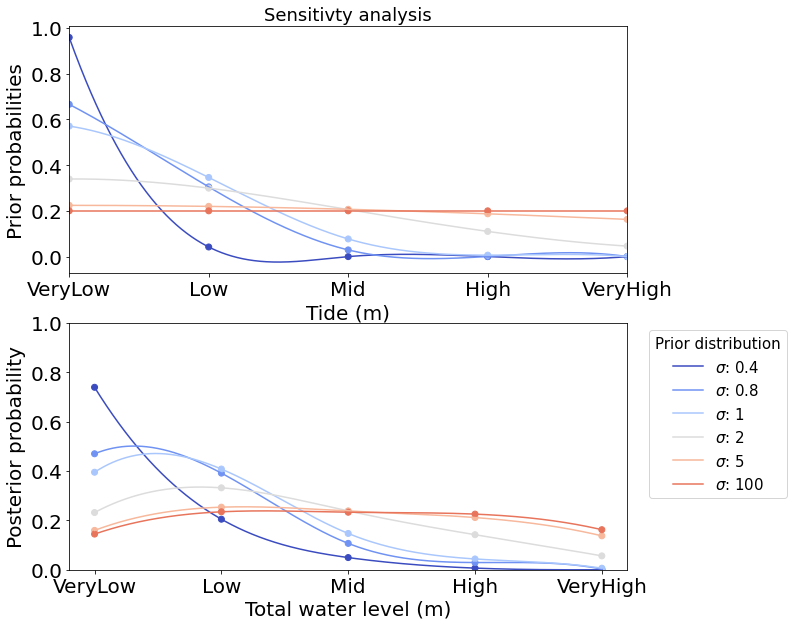

({0:       0.4       0.8       1.0       2.0       5.0       100.0
  0  0.738659  0.469607  0.394858  0.231723  0.159437  0.144581
  1  0.204804  0.391275  0.407729  0.331767  0.253497  0.234718
  2  0.049518  0.106937  0.147107  0.238150  0.238051  0.232989
  3  0.006825  0.029372  0.043860  0.142028  0.211510  0.225378
  4  0.000194  0.002810  0.006445  0.056332  0.137506  0.162333},
 <Figure size 720x720 with 2 Axes>)

In [53]:
df_tide_VL_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','VeryLow','TWL')
df_tide_VL_post



In [ ]:
df_tide_L_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','Low','TWL_point_110')
df_tide_L_post

In [ ]:
df_tide_H_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','High','TWL_point_110')
df_tide_H_post

In [ ]:
df_tide_VH_post = BNModel().univariant_sensitivity(lagoon_model_dict,'Tide','VeryHigh','TWL_point_110')
df_tide_VH_post

### MSL on TWL less tide

In [ ]:
df_MSL_VL_post = BNModel().univariant_sensitivity(lagoon_model_dict,'MSL','VeryLow','TWL_point_110')
df_MSL_VL_post

In [ ]:
df_MSL_H_post = BNModel().univariant_sensitivity(lagoon_model_dict,'MSL','High','TWL_point_110')
df_MSL_H_post

In [ ]:
# df_MSL_VH_post = BNModel().univariant_sensitivity(lagoon_model_dict,0,'MSL','VeryHigh','TWL_point_110_less')
# df_MSL_VH_post

### Hs_offshore on TWL less tide

In [ ]:
# df_Wind_VL_post = BNModel().univariant_sensitivity(lagoon_model_dict,0,'Wind','VeryLow','TWL_point_110_less_tide')
# df_Wind_VL_post

# MSL Priors based on Future Projections

## Get the distribution of MSL data currently

In [229]:
def grouping_bins(data):
    grouped_dict = {}

    for bin_name in np.unique(data):
        grouped_dict.update({
            bin_name:len(data[data==bin_name])
        })
        
    df_grouped = pd.DataFrame.from_dict(grouped_dict,orient='index')
    
    return(df_grouped)

In [230]:
def descretiser(bin_edges,bin_names,data_array):
    
    discretised_array = np.empty(len(data_array)).astype(str)
    
    for lower, upper, bin_name in zip(
        bin_edges[:-1],
        bin_edges[1:],
        bin_names):
        
        discretised_array[(data_array>lower)&(data_array<upper)] = bin_name

        # Now Include out of bounds values in the upper and lower bins
        discretised_array[data_array<np.min(bin_edges)] = bin_names[0]
        discretised_array[data_array>np.max(bin_edges)] = bin_names[-1]
        
    return(discretised_array)
                    

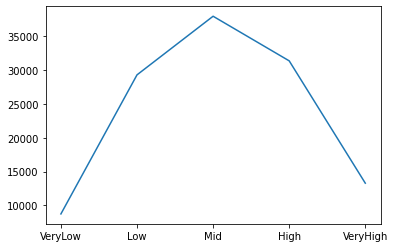

In [231]:
# Bin the MSL data
MSL_data = lagoon_model_dict['variables']['MSL']['training_data'][0]

# Grouping the bins 
MSL_bins_grouped = grouping_bins(MSL_data)

# Put the bins in the right order
df_MSL_distribution = MSL_bins_grouped.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])

# Plot the data
plt.plot(df_MSL_distribution)

## Add the Global average for now

In [232]:
# Get the preprocessed data to add to
MSL_training_data_preprocessed = lagoon_model_dict['variables']['MSL']['training_data_preprocessed'][0]
MSL_testing_data_preprocessed = lagoon_model_dict['variables']['MSL']['testing_data_preprocessed'][0]

# Print some stats to get an idea of how adding SLR will affect the data
print(np.min(MSL_training_data_preprocessed))
print(np.max(MSL_training_data_preprocessed))
print(np.mean(MSL_training_data_preprocessed))
print(np.median(MSL_training_data_preprocessed))

-0.2273485683881827
0.2075872808110124
-0.0007373993679964208
-0.0010175677919509


In [233]:
# Based on a 2 mm/yr rate
mean_SLR_2050 = 2*29/1000
mean_SLR_2100 = 2*59/1000

# Get MSLs adjusted for regional sea level rise
MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100

In [234]:
# Using the bins from before, discretise the results
bin_edges = lagoon_model_dict['variables']['MSL']['bin_edges'][0]
bin_names = lagoon_model_dict['variables']['MSL']['discretisation']['bin_names']

# Normalise the data
df_MSL_2021 = df_MSL_distribution/np.nansum(df_MSL_distribution)

# Calculated discretised MSL for the scenarios
MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
MSL_2050_discretised = descretiser(bin_edges,bin_names,MSL_2050)
df_MSL_2050 = grouping_bins(MSL_2050_discretised)
df_MSL_2050 = df_MSL_2050.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
df_MSL_2050[df_MSL_2050.isna()] = 0.001
df_MSL_2050 = df_MSL_2050/np.nansum(df_MSL_2050)

# Calculated discretised MSL for the scenarios
MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100
MSL_2100_discretised = descretiser(bin_edges,bin_names,MSL_2100)
df_MSL_2100 = grouping_bins(MSL_2100_discretised)
df_MSL_2100 = df_MSL_2100.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
df_MSL_2100[df_MSL_2100.isna()] = 0.001
df_MSL_2100 = df_MSL_2100/np.nansum(df_MSL_2100)


### Set evidence of 2050

In [235]:
# Create dict of evidence
MSL_2050_evidence_dict = {
    'MSL':list(df_MSL_2050[0])
}

# Add evidence for MSL to the model dict
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2050_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2050_evidence_dict)

# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# TWL posterior 2050
TWL_MSL_2050_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
df_TWL_MSL_2050_posterior = pd.DataFrame.from_dict(TWL_MSL_2050_posterior_dict,orient='index')

KeyError: 'TWL_point_110'

In [ ]:
# Create dict of evidence
MSL_2100_evidence_dict = {
    'MSL':list(df_MSL_2100[0])
}

# Add evidence for MSL to the model dict
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2100_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2100_evidence_dict)

# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# TWL posterior 2100
TWL_MSL_2100_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
df_TWL_MSL_2100_posterior = pd.DataFrame.from_dict(TWL_MSL_2100_posterior_dict,orient='index')

In [ ]:
# get the original data to compare it to
TWL_training_dict = lagoon_model_dict['variables']['TWL_point_110']['training_data'][0]
df_TWL_training = grouping_bins(TWL_training_dict)
df_TWL_training = df_TWL_training.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
df_TWL_training[df_TWL_training.isna()] = 0.001
df_TWL_training = df_TWL_training/np.nansum(df_TWL_training)

# Create an extra set of dfs for data as a fraction of original
TWL_MSL_2050 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2050_posterior[0])]
TWL_MSL_2100 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2100_posterior[0])]
df_TWL_MSL_2050 = pd.DataFrame(TWL_MSL_2050).set_index(0)
df_TWL_MSL_2100 = pd.DataFrame(TWL_MSL_2100).set_index(0)

In [ ]:

# Set up the figure
fig = plt.figure(figsize=(10,15))
fig.subplots_adjust(hspace=0.5)
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0))
ax3 = plt.subplot2grid((3,1),(2,0))

# Plot MSL data and prior distributions
ax1.plot(df_MSL_2021,c='k')
ax1.plot(df_MSL_2050,c='b')
ax1.plot(df_MSL_2100,c='r')

# Plot posterior distributions compared to original data
output_2021, = ax2.plot(df_TWL_training,c='k')
output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')

# Plot posterior distributions as a fraction of the original data
output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
ax3_xlims = ax3.get_xlim()
ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
ax3.set_xlim(ax3_xlims)

# Format the graph
ax1.set_ylabel('Probability')
ax1.set_xlabel('Mean Sea Level')
ax2.set_ylabel('Probability')
ax2.set_xlabel('Total Water Level')
ax3.set_ylabel('Probability/Probability')
ax3.set_xlabel('Total Water Level')

ax1.legend([output_2021,output_2050,output_2100],['Present','2050','2100'])


# Load in some IPCC RSL Data

In [ ]:
# The IPCC data (Openheimer et al., 2019, IPCC Ch4) is relative to the 1983-2005
# Antonio's data is 1993-2017

# It's not clear to me right now if the IPCC data is relative to the 1983-2005 value globally averaged, 
# or if it varies regionally


In [ ]:
import xarray as xr
tarawa_lat = 1.333
tarawa_long = 173

In [ ]:
# Load the RSLD from IPCC, chapter
ds_RSLR_2040_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2040.nc')
ds_RSLR_2040_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2040.nc')
ds_RSLR_2040_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2040.nc')

ds_RSLR_2055_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2055.nc')
ds_RSLR_2055_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2055.nc')
ds_RSLR_2055_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2055.nc')

ds_RSLR_2090_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2090.nc')
ds_RSLR_2090_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2090.nc')
ds_RSLR_2090_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2090.nc')


In [ ]:
# Get the RSLR for Tarawa specifically
RSLR_2040_rcp26 = float(ds_RSLR_2040_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2055_rcp26 = float(ds_RSLR_2055_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2090_rcp26 = float(ds_RSLR_2090_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

RSLR_2040_rcp45 = float(ds_RSLR_2040_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2055_rcp45 = float(ds_RSLR_2055_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2090_rcp45 = float(ds_RSLR_2090_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

RSLR_2040_rcp85 = float(ds_RSLR_2040_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2055_rcp85 = float(ds_RSLR_2055_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
RSLR_2090_rcp85 = float(ds_RSLR_2090_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

#### These values are relative to PI?? If so, I doubt Antonio's numbers are PI---so this needs to be adjusted for

### Use RCP Scenarios to set evidence

In [ ]:
# Get MSLs adjusted for regional sea level rise
MSL_2040_rcp26 = MSL_training_data_preprocessed+RSLR_2040_rcp26
MSL_2055_rcp26 = MSL_training_data_preprocessed+RSLR_2055_rcp26
MSL_2090_rcp26 = MSL_training_data_preprocessed+RSLR_2090_rcp26

MSL_2040_rcp45 = MSL_training_data_preprocessed+RSLR_2040_rcp45
MSL_2055_rcp45 = MSL_training_data_preprocessed+RSLR_2055_rcp45
MSL_2090_rcp45 = MSL_training_data_preprocessed+RSLR_2090_rcp45

MSL_2040_rcp85 = MSL_training_data_preprocessed+RSLR_2040_rcp85
MSL_2055_rcp85 = MSL_training_data_preprocessed+RSLR_2055_rcp85
MSL_2090_rcp85 = MSL_training_data_preprocessed+RSLR_2090_rcp85

In [ ]:
def test_model(evidence_array,model_dict):

    # Adjust MSL for difference between antonio data and IPCC data
    SLR_adjustment = 2*11/1000
    evidence_array -= SLR_adjustment
    
    # Dicretise the data
    MSL_discretised = descretiser(bin_edges,bin_names,evidence_array)
    df_MSL = grouping_bins(MSL_discretised)
    df_MSL = df_MSL.reindex(model_dict['variables']['MSL']['discretisation']['bin_names'])
    df_MSL[df_MSL.isna()] = 0.001
    df_MSL = df_MSL/np.nansum(df_MSL)
    
    # Create dict of evidence
    MSL_evidence_dict = {
        'MSL':list(df_MSL[0])
    }

    # Add evidence for MSL to the model dict
    model_dict = BNModel().add_evidence_to_dict(model_dict,MSL_evidence_dict)

    # Set evidence and get beliefs
    model_dict = BNModel().update_evidence(model_dict)

    # TWL posterior 2100
    TWL_MSL_posterior_dict = model_dict['variables']['TWL_point_110']['resulting_probs'][0]
    df_TWL_posterior = pd.DataFrame.from_dict(TWL_MSL_posterior_dict,orient='index')
    
    return(df_TWL_posterior,df_MSL)

In [ ]:
IPCC_posteriors_dict = {}
MSL_prior_dict = {}

MSL_array_list = [MSL_2040_rcp26,MSL_2055_rcp26,MSL_2090_rcp26,MSL_2040_rcp45,MSL_2055_rcp45,MSL_2090_rcp45,MSL_2040_rcp85,MSL_2055_rcp85,MSL_2090_rcp85]

for array, label in zip(MSL_array_list,
                        ['RCP2.6, 2040','RCP2.6, 2055','RCP2.6, 2090','RCP4.5, 2040','RCP4.5, 2055','RCP4.5, 2090','RCP8.5, 2040','RCP8.5, 2055','RCP8.5, 2090']):
    
    df_TWL_posterior, df_MSL = test_model(array, lagoon_model_dict)
    
    IPCC_posteriors_dict.update({
        label:df_TWL_posterior
    })
    
    MSL_prior_dict.update({
        label:df_MSL
    })

In [ ]:

# Set up the figure
fig = plt.figure(figsize=(10,15))
fig.subplots_adjust(hspace=0.5)
ax1 = plt.subplot2grid((3,1),(0,0))
ax2 = plt.subplot2grid((3,1),(1,0))
ax3 = plt.subplot2grid((3,1),(2,0))

# # Plot MSL data and prior distributions
# ax1.plot(df_MSL_2021,c='k')
# ax1.plot(df_MSL_2050,c='b')
# ax1.plot(df_MSL_2100,c='r')
for key,df_prior in MSL_prior_dict.items():
    ax1.plot(df_prior)

# # Plot posterior distributions compared to original data
# output_2021, = ax2.plot(df_TWL_training,c='k')
# output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
# output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')
outputs = []

for key,posterior_array in IPCC_posteriors_dict.items():
    output, = ax2.plot(posterior_array)
    outputs.append(output)

# # Plot posterior distributions as a fraction of the original data
# output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
# output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
# ax3_xlims = ax3.get_xlim()
# ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
# ax3.set_xlim(ax3_xlims)

# Format the graph
ax1.set_ylabel('Probability')
ax1.set_xlabel('Mean Sea Level')
ax2.set_ylabel('Probability')
ax2.set_xlabel('Total Water Level')
ax3.set_ylabel('Probability/Probability')
ax3.set_xlabel('Total Water Level')

ax1.legend(outputs,IPCC_posteriors_dict.keys())


# Mean wave height and period

In [ ]:
Hs_mean = lagoon_model_dict['variables']['Hs_offshore']['training_data_preprocessed'][0]
np.mean(Hs_mean)

In [ ]:
Tm_mean = lagoon_model_dict['variables']['Tm_offshore']['training_data_preprocessed'][0]
np.mean(Tm_mean)

In [ ]:
lagoon_model_dict['variables']['Hs_offshore']

# Interactive Plots

In [38]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from colormap import rgb2hex

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [39]:
df_ocean_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_outer_reef_xyxy.txt',delim_whitespace=True,header=None)
df_lagoon_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_inner_lagoon_xyxy.txt',delim_whitespace=True,header=None)


df_lagoon_profiles.columns = ['reef_long','reef_lat','shore_long','shore_lat','reef_depth']
df_ocean_profiles.columns = ['reef_long','reef_lat','shore_long','shore_lat','reef_width','reef_depth','forereef_slope']

In [40]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)

def ocean_model_location(ocean_model_dict,location_details,ocean_evidence_dict):
    
    '''
    function for adding the location information for the ocean side model to the evidence dictionary
    '''
    
    reef_width_bin_edges = ocean_model_dict['variables']['reef_width']['bin_edges'][0]
    reef_width = location_details['reef_width']

    reef_width_bin = bin_locator(reef_width,reef_width_bin_edges)

    reef_depth_bin_edges = ocean_model_dict['variables']['reef_depth']['bin_edges'][0]
    reef_depth = location_details['reef_depth']

    reef_depth_bin = bin_locator(reef_depth,reef_depth_bin_edges)

    forereef_slope_bin_edges = ocean_model_dict['variables']['forereef_slope']['bin_edges'][0]
    forereef_slope = location_details['forereef_slope']

    forereef_slope_bin = bin_locator(forereef_slope,forereef_slope_bin_edges)

    reef_width_evidence = [0]*(len(reef_width_bin_edges)-1)
    reef_width_evidence[reef_width_bin] = 1

    reef_depth_evidence = [0]*(len(reef_depth_bin_edges)-1)
    reef_depth_evidence[reef_depth_bin] = 1

    forereef_slope_evidence = [0]*(len(forereef_slope_bin_edges)-1)
    forereef_slope_evidence[forereef_slope_bin] = 1

    ocean_evidence_dict.update({
        'reef_width':reef_width_evidence,
        'reef_depth':reef_depth_evidence,
        'forereef_slope':forereef_slope_evidence
    })

    # Add evidence to model dict
    ocean_model_location_dict = BNModel().add_evidence_to_dict(ocean_model_dict,ocean_evidence_dict)
    
    # Set evidence and get beliefs
    ocean_model_location_dict = BNModel().update_evidence(ocean_model_location_dict)
    
    return(ocean_model_location_dict)

def location_probabilities(ocean_evidence_dict):
    '''
    
    Function for setting evidence and determing probabilties for twl at each point around the island based 
    on the reef characteristics at each location
    
    '''
    
    location_probabilities_dict = {}
    
    for index,row in df_ocean_profiles.iterrows():
        ocean_model_location_dict = ocean_model_location(ocean_model_dict,row,ocean_evidence_dict)
        location_probabilities = ocean_model_location_dict['variables']['TWL']['resulting_probs'][0]

        largest_cat = pd.DataFrame.from_dict(location_probabilities,orient='index').idxmax()[0]

        location_probabilities_dict.update({
            (row.reef_long,row.reef_lat):\
                ocean_model_dict['variables']['TWL']['discretisation']['bin_names'].index(largest_cat)
        })
        
    return(location_probabilities_dict)

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["long"],
                                                    X["lat"])),
                            properties=dict(name=X["most_likely_twl"])))
    df.apply(insert_features, axis=1)
        
    return(geojson.FeatureCollection(features))

In [41]:
def test_figure(tide_bin,msl_bin,wave_height_bin):
    
    # Create an empty dictionary for the evidence and populate as you go
    ocean_evidence_dict = {}
    
    ## Set Tide in the evidence dict to be as indicated in the dropdown
    tide_bin_index = ocean_model_dict['variables']['Tide']['discretisation']['bin_names'].index(tide_bin)
    # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
    tide_evidence = [0 for x in ocean_model_dict['variables']['Tide']['discretisation']['bin_names']]
    tide_evidence[tide_bin_index] = 1
    ocean_evidence_dict.update({
        'Tide':tide_evidence
    })
    
    ## Set msl in the evidence dict to be as indicated in the dropdown
    msl_bin_index = ocean_model_dict['variables']['MSL']['discretisation']['bin_names'].index(msl_bin)
    # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
    msl_evidence = [0 for x in ocean_model_dict['variables']['MSL']['discretisation']['bin_names']]
    msl_evidence[msl_bin_index] = 1
    ocean_evidence_dict.update({
        'MSL':msl_evidence
    })
    
    ## Set Tide in the evidence dict to be as indicated in the dropdown
    wave_height_bin_index = ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names'].index(wave_height_bin)
    # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
    wave_height_evidence = [0 for x in ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names']]
    wave_height_evidence[wave_height_bin_index] = 1
    ocean_evidence_dict.update({
        'Hs_offshore':wave_height_evidence
    })
    
#     ## Set Tide in the evidence dict to be as indicated in the dropdown
#     tide_bin_index = ocean_model_dict['variables']['Tide']['discretisation']['bin_names'].index(tide_bin)
#     # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#     tide_evidence = [0 for x in ocean_model_dict['variables']['Tide']['discretisation']['bin_names']]
#     tide_evidence[tide_bin_index] = 1
#     ocean_evidence_dict.update({
#         'Tide':tide_evidence
#     })
    
    # get the probability dictionary
    location_probabilities_dict = location_probabilities(ocean_evidence_dict)
    # Create dataframe to plot
    df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
    df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
    df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
    df_twl_locations.reset_index(drop=True,inplace=True)
    twl_bin_edges = [round(x,2) for x in ocean_model_dict['variables']['TWL']['bin_edges'][0]]
    twl_bins = ocean_model_dict['variables']['TWL']['discretisation']['bin_names']
    
    map_osm = folium.Map(location=[1.448888, 172.991794],zoom_start=11)

    colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(twl_bins),1/(len(twl_bins)-1)))
    colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(twl_bins),1)}
    
    data = data2geojson(df_twl_locations)

    colors_hex_points = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]

    for feature,color in zip(data['features'],colors_hex_points):
        feature['properties'] = {'color':color,'weight':1,'markerColor':color,'fillOpacity':1,'fillColor':color}
        long,lat = feature['geometry']['coordinates']
        
        marker = folium.CircleMarker([lat,long],color=color, # , popup='Timberline Lodge'
                                   fill_color=color,fill=True,fill_opacity='1',radius=5)
        marker.add_to(map_osm)
        
    twl_bin_edge_labels = ['{}: {} to {} m'.format(
        bin_name,x,y) for bin_name,x,y in zip(twl_bins,twl_bin_edges[:-1],twl_bin_edges[1:])]
        
    output_list = []
    for rgb_color in colours_rgb:
        output = plt.scatter([],[],color=rgb_color)
        output_list.append(output)
        
    plt.legend(output_list,twl_bin_edge_labels,title='Total water level anomaly')
    plt.axis('off')
    
    map_osm.save('test.html')
        
    return(map_osm)
    

# Define the bins for the dropdown
tide_bins = ocean_model_dict['variables']['Tide']['discretisation']['bin_names']
msl_bins = ocean_model_dict['variables']['MSL']['discretisation']['bin_names']
wave_height_bins = ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names']

# Create the plot with the widget
map_osm = interact_manual(test_figure,
                tide_bin = widgets.Dropdown(options=tide_bins,value='Mid',description='Tide',disabled=False),
                msl_bin = widgets.Dropdown(options=msl_bins,value='Mid',description='MSL',disabled=False),
                wave_height_bin = widgets.Dropdown(options=wave_height_bins,value='Mid',description='Wave height',disabled=False)
               )

map_osm

interactive(children=(Dropdown(description='Tide', index=2, options=('VeryLow', 'Low', 'Mid', 'High', 'VeryHig…

<function __main__.test_figure(tide_bin, msl_bin, wave_height_bin)>

# Testing Code

In [42]:
df_ocean


,TWL,Tide,MSL,wind_u,wind_v,long,lat,Hs_offshore,Tm_offshore,Dir_offshore,reef_width,reef_depth,forereef_slope,TWL_less_Tide
0,-0.003878,-0.489179,0.077363,0.724319,1.845566,172.92001,1.359241,1.997889,12.130004,39.839233,1815.70350,2.532653,0.018279,-0.485301
1,-0.459240,-0.627458,-0.158340,-4.919907,-1.378174,172.92001,1.359241,1.231434,5.760602,55.918564,1815.70350,2.532653,0.018279,-0.168218
2,0.298174,-0.044354,-0.004419,-3.321045,0.507874,172.92001,1.359241,1.635806,8.167212,59.223343,1815.70350,2.532653,0.018279,-0.342528
3,0.145323,-0.158879,-0.014415,-3.546463,1.469955,172.92001,1.359241,1.206625,5.085305,53.540924,1815.70350,2.532653,0.018279,-0.304203
4,0.978581,0.679516,0.001992,-4.321671,1.901627,172.92001,1.359241,1.783289,6.070200,37.366241,1815.70350,2.532653,0.018279,-0.299066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175899,-0.062203,-0.580713,0.123654,-6.787476,-1.321213,173.05073,1.357409,0.338373,1.590390,62.994675,495.52852,1.348382,0.127972,-0.518509
175900,0.423979,0.060231,0.071673,0.787109,-2.430847,173.05073,1.357409,0.174570,1.603255,311.097595,495.52852,1.348382,0.127972,-0.363748
175901,0.375429,0.066490,0.001026,-1.563248,2.084686,173.05073,1.357409,0.166400,1.015431,91.216080,495.52852,1.348382,0.127972,-0.308939
175902,0.945194,0.500272,-0.016428,-8.150970,2.118027,173.05073,1.357409,0.457096,1.761401,76.284973,495.52852,1.348382,0.127972,-0.444922


In [97]:
twl_bin_edge_labels

['VeryLow: -1.02 to -0.02 m',
 'Low: -0.02 to 0.41 m',
 'Mid: 0.41 to 0.82 m',
 'High: 0.82 to 1.28 m',
 'VeryHigh: 1.28 to 2.69 m']

In [61]:
rgb2hex(int(255*colours[i][0],colours[i][1],colours[i][2])

TypeError: %X format: an integer is required, not numpy.float64

In [62]:
int(0.4*255)

102

NameError: name 'colour_dict' is not defined

In [292]:
twl_bins

['VeryLow', 'Low', 'Mid', 'High', 'VeryHigh']

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [280]:
10/10

1.0